In [1]:
# Install packages
%pip install networkx
%pip install numpy
%pip install tqdm
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [15]:
# The starter code is short and simple, take a look!
from starter import *
import random

# Phase 1 - Create Inputs

In [16]:
# Add edges with G.add_edge(u, v, weight=w)
# Idea: consider making the inputs with a solution in mind, 
# such that you know the solution when the outputs are released

def small(G: nx.Graph):
    # TODO add edges to complete the small input
    while G.size(weight = "weight") < 500_000:
        u = random.choice(range(0, N_SMALL))
        v = random.choice(list(range(0, u)) + list(range(u + 1, N_SMALL)))
        w = random.choice(range(1, 1_001))
        G.add_edge(u, v, weight=w)
    
def medium(G: nx.Graph):
    # TODO add edges to complete the medium input
    while G.size(weight = "weight") < 500_000:
        u = random.choice(range(0, N_MEDIUM))
        v = random.choice(list(range(0, u)) + list(range(u + 1, N_MEDIUM)))
        w = random.choice(range(1, 1_001))
        G.add_edge(u, v, weight=w)
    
def large(G: nx.Graph):
    # TODO add edges to complete the large input
    while G.size(weight = "weight") < 500_000:
        u = random.choice(range(0, N_LARGE))
        v = random.choice(list(range(0, u)) + list(range(u + 1, N_LARGE)))
        w = random.choice(range(1, 1_001))
        G.add_edge(u, v, weight=w)


In [18]:
G = nx.empty_graph(N_SMALL)
small(G)
write_input(G, 'small.in')

G = nx.empty_graph(N_MEDIUM)
medium(G)
write_input(G, 'medium.in')

G = nx.empty_graph(N_LARGE)
large(G)
write_input(G, 'large.in')

# Phase 2 - Implement your Solver

In [169]:
from random import choice
from collections import defaultdict

def anneal_param(G: nx.graph):
    T = 100
    Tf = 0.01
    iter = G.number_of_nodes() ^ 2
    alpha = 0.99
    return T, Tf, iter, alpha

def replace(G: nx.graph, teams, penguin: int, replaced_team: int):
    old_team = G.nodes[penguin]['team']
    teams[old_team].remove(penguin)
    teams[replaced_team].append(penguin)
    G.nodes[penguin]['team'] = replaced_team

def init_G_team(G: nx.Graph, no_teams):

    teams = defaultdict(list)

    all_nodes = list(G.nodes)
    for team_id in range(1, 1 + no_teams):
        indegree = [0, float('inf')]
        for n in all_nodes:
            if G.degree(n) < indegree[1]:
                indegree = [n, G.degree(n)]
        start_node = indegree[0]
        all_nodes.remove(start_node)
        G.nodes[start_node]['team'] = team_id
        teams[team_id].append(start_node)
        
    team_size = G.number_of_nodes() // no_teams    
    
    count = 0
    while all_nodes:
        team_to_add = (count % no_teams) + 1
        add_node(teams, team_to_add, all_nodes, G)
        count += 1

    return teams

def add_node(teams, team_id, all_nodes, G):
    team_nodes = teams[team_id]
    possible_nodes = set(all_nodes.copy())
    neighbours = set()
    # Accumulate all neighbours 
    for node in team_nodes:
        for avail_node in all_nodes:
            if G.has_edge(avail_node, node):
                neighbours.add(avail_node)
    possible_nodes.difference_update(neighbours) 
    non_neighbours = list(possible_nodes)
                          
    # First choose among non-neighbours
    if non_neighbours:
        # Select random non-neighbour who doesn't have a team_id yet
        # Choose non-neighbour with the smallest indegree first
        indegree = [0, float('inf')]
        for n in non_neighbours:
            if G.degree(n) < indegree[1]:
                indegree = [n, G.degree(n)]
        target_node = indegree[0]
        all_nodes.remove(target_node)
        teams[team_id].append(target_node)
        G.nodes[target_node]['team'] = team_id
    else:
        # If no non-neighbours, choose neighbouring node with min edge weight
        min_node = [0, float('inf')]

        for n in neighbours:
            sum_weights = 0
            for n1 in teams[team_id]:
                if G.has_edge(n, n1):
                    sum_weights += G[n][n1]['weight']
            if sum_weights < min_node[1]:
                min_node = [n, sum_weights]
        teams[team_id].append(min_node[0])
        all_nodes.remove(min_node[0])
        G.nodes[min_node[0]]['team'] = team_id

def update_Cw_score(G: nx.Graph, previousScore: float, penguin: int, i: int, j: int):
    
    # get all neighbours and see which are from the same team
    
    # go through all neighbours, and get total weights of all edges from team i and all edges from team j
    team_i_weight = 0
    team_j_weight = 0
    for neighbour in G[penguin]:
        if G.nodes[neighbour]['team'] == i:
            team_i_weight += G[penguin][neighbour]['weight']
        if G.nodes[neighbour]['team'] == j:
            team_j_weight += G[penguin][neighbour]['weight']
    
    return previousScore - team_i_weight + team_j_weight

def update_Cp_score(G: nx.Graph, teams, previousScore: float, penguin: int, i: int, j:int):
    # find b 
    b = np.log(previousScore) / 70
    
    # find number of people in team i
    p_i = len(teams[i])
    p_j = len(teams[j])
    
    n = G.number_of_nodes()
    k = len(teams.keys())
    
    b_i = (p_i / n) - (1 / k)
    b_j = (p_j / n) - (1 / k)
    
    new_b = round( (b ** 2) - (b_i ** 2) - (b_j ** 2) + ((b_i - (1/n)) ** 2) + ((b_j + (1/n)) ** 2), 3) ** 0.5
    
    return math.exp(70 * new_b)

def solve_fixing_k(G: nx.Graph):

    T, Tf, alpha = 100, 0.01, 0.99
    no_teams, flag, cost = 2, True, float('inf')
    
    while flag:
        no_teams += 1
        init_G_team(G, no_teams)
        result = score(G)
        if result < cost:
            G_result = G.copy()
            cost = result
        else:
            flag = False
        
    optTeams = no_teams - 1

    return no_teams

In [107]:
G = read_input('large.in')
print(solve_fixing_k(G))

7


In [132]:
def solve(G: nx.Graph):
    # TODO implement this function with your solver
    # Assign a team to v with G.nodes[v]['team'] = team_id
    # Access the team of v with team_id = G.nodes[v]['team']

    T, Tf, iter, alpha = anneal_param(G)
    no_teams = solve_fixing_k(G)
    teams = init_G_team(G, no_teams)
    cw, ck, cp = score(G, separated=True)

    while T > Tf:
        # eps = random.randint(-1, 1)
        cost = cw + ck + cp
        used_pair = []

        for _ in range(iter):
            node, replaced_team = random.randint(0, G.number_of_nodes()-1), random.randint(1, no_teams-1)
            if (node, replaced_team) not in used_pair:
                used_pair.append((node, replaced_team))
                new_cost = ck + update_Cw_score(G, cw, node, G.nodes[node]['team'], replaced_team) + update_Cp_score(G, teams, cp, node, G.nodes[node]['team'], replaced_team)
                delta = new_cost - cost
                if  delta >= 0:
                    prob = math.exp(-delta/T)
                if delta < 0 or (delta >= 0 and random.random() < prob):
                    node, replaced_team = node, replaced_team
                    ck, cp = update_Cw_score(G, cw, node, G.nodes[node]['team'], replaced_team), update_Cp_score(G, teams, cp, node, G.nodes[node]['team'], replaced_team)
                    replace(G, teams, node, replaced_team)

        T *= alpha



C:\Users\22749\AppData\Local\Temp\ipykernel_26052\2135500829.py:110: RuntimeWarning: invalid value encountered in double_scalars
  new_b = round( (b ** 2) - (b_i ** 2) - (b_j ** 2) + ((b_i - (1/n)) ** 2) + ((b_j + (1/n)) ** 2), 3) ** 0.5


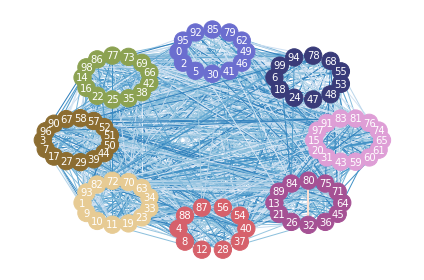

5584.303969737704

In [170]:
G = read_input('small.in')
solve(G)
validate_output(G)
visualize(G)
score(G)

In [168]:
run(solve, 'small.in', 'small.out', True)

C:\Users\22749\AppData\Local\Temp\ipykernel_26052\922626286.py:110: RuntimeWarning: invalid value encountered in double_scalars
  new_b = round( (b ** 2) - (b_i ** 2) - (b_j ** 2) + ((b_i - (1/n)) ** 2) + ((b_j + (1/n)) ** 2), 3) ** 0.5


small.in: cost 5584.259650085521


In [171]:
run(solve, 'large.in', 'large.out', True)

large.in: cost 2013.139360198725


In [172]:
run_all(solve, 'inputs', 'outputs', True)
tar('outputs', True)

  0%|          | 0/780 [00:00<?, ?it/s]

inputs\large1.in: cost 201066.70143745365
inputs\large10.in: cost 30960.44450645275
inputs\large100.in: cost 2018.084563881385
inputs\large101.in: cost 133447.0251008923
